In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import umap

In [2]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [4]:
print(train_features_df.shape)
train_features_df.head(3)

(40242, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19790,0.69605,0.40400,0.30834,0.19317,0.71895,0.38837,0.38668,0.62494,0.87362,...,0.61045,0.41907,0.64945,0.65199,0.22660,0.32108,0.29776,0.26173,0.34524,0.32151
1,0.18605,0.68873,0.41051,0.31982,0.19885,0.72510,0.39552,0.38362,0.65094,0.89679,...,0.61393,0.38269,0.63814,0.68204,0.23700,0.32808,0.27981,0.26893,0.34938,0.33179
2,0.19083,0.66276,0.38585,0.31437,0.20415,0.71380,0.38701,0.36699,0.60932,0.88492,...,0.60850,0.41850,0.63529,0.65208,0.22852,0.32710,0.29371,0.27159,0.33871,0.31965


In [5]:
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [6]:
train_features_df = shuffle_each_column(train_features_df)
valid_features_df = shuffle_each_column(valid_features_df)

In [7]:
encoder_architecture=[250]
decoder_architecture=[250]

In [9]:
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=90,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=50,
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0.06,
    verbose=True,
)
cp_vae.compile_vae()

In [11]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

In [13]:
cp_vae.vae

In [15]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,54.869907,53.650944,1.218955,0.0,12.652170,11.424767,1.227403,0.0
1,8.247378,7.314881,0.932502,0.0,6.626889,5.694563,0.932327,0.0
2,5.036562,4.318009,0.718558,0.0,4.041628,3.429634,0.611995,0.0
3,3.414021,2.901894,0.512127,0.0,2.988549,2.513977,0.474573,0.0
4,2.399954,2.072725,0.327231,0.0,2.063956,1.792457,0.271500,0.0
5,1.800817,1.614821,0.185997,0.0,1.577329,1.417694,0.159635,0.0
6,1.454554,1.359425,0.095128,0.0,1.309228,1.231888,0.077339,0.0
7,1.267950,1.218242,0.049709,0.0,1.167057,1.127098,0.039958,0.0
8,1.171953,1.141753,0.030201,0.0,1.097938,1.068833,0.029106,0.0
9,1.120238,1.099782,0.020457,0.0,1.057450,1.037367,0.020083,0.0


In [7]:
history_df.to_csv('level4_training_random.csv')

In [8]:
history_df = pd.read_csv('level4_training_random.csv')

In [9]:
original_training_data  = pd.read_csv('level4_training.csv')

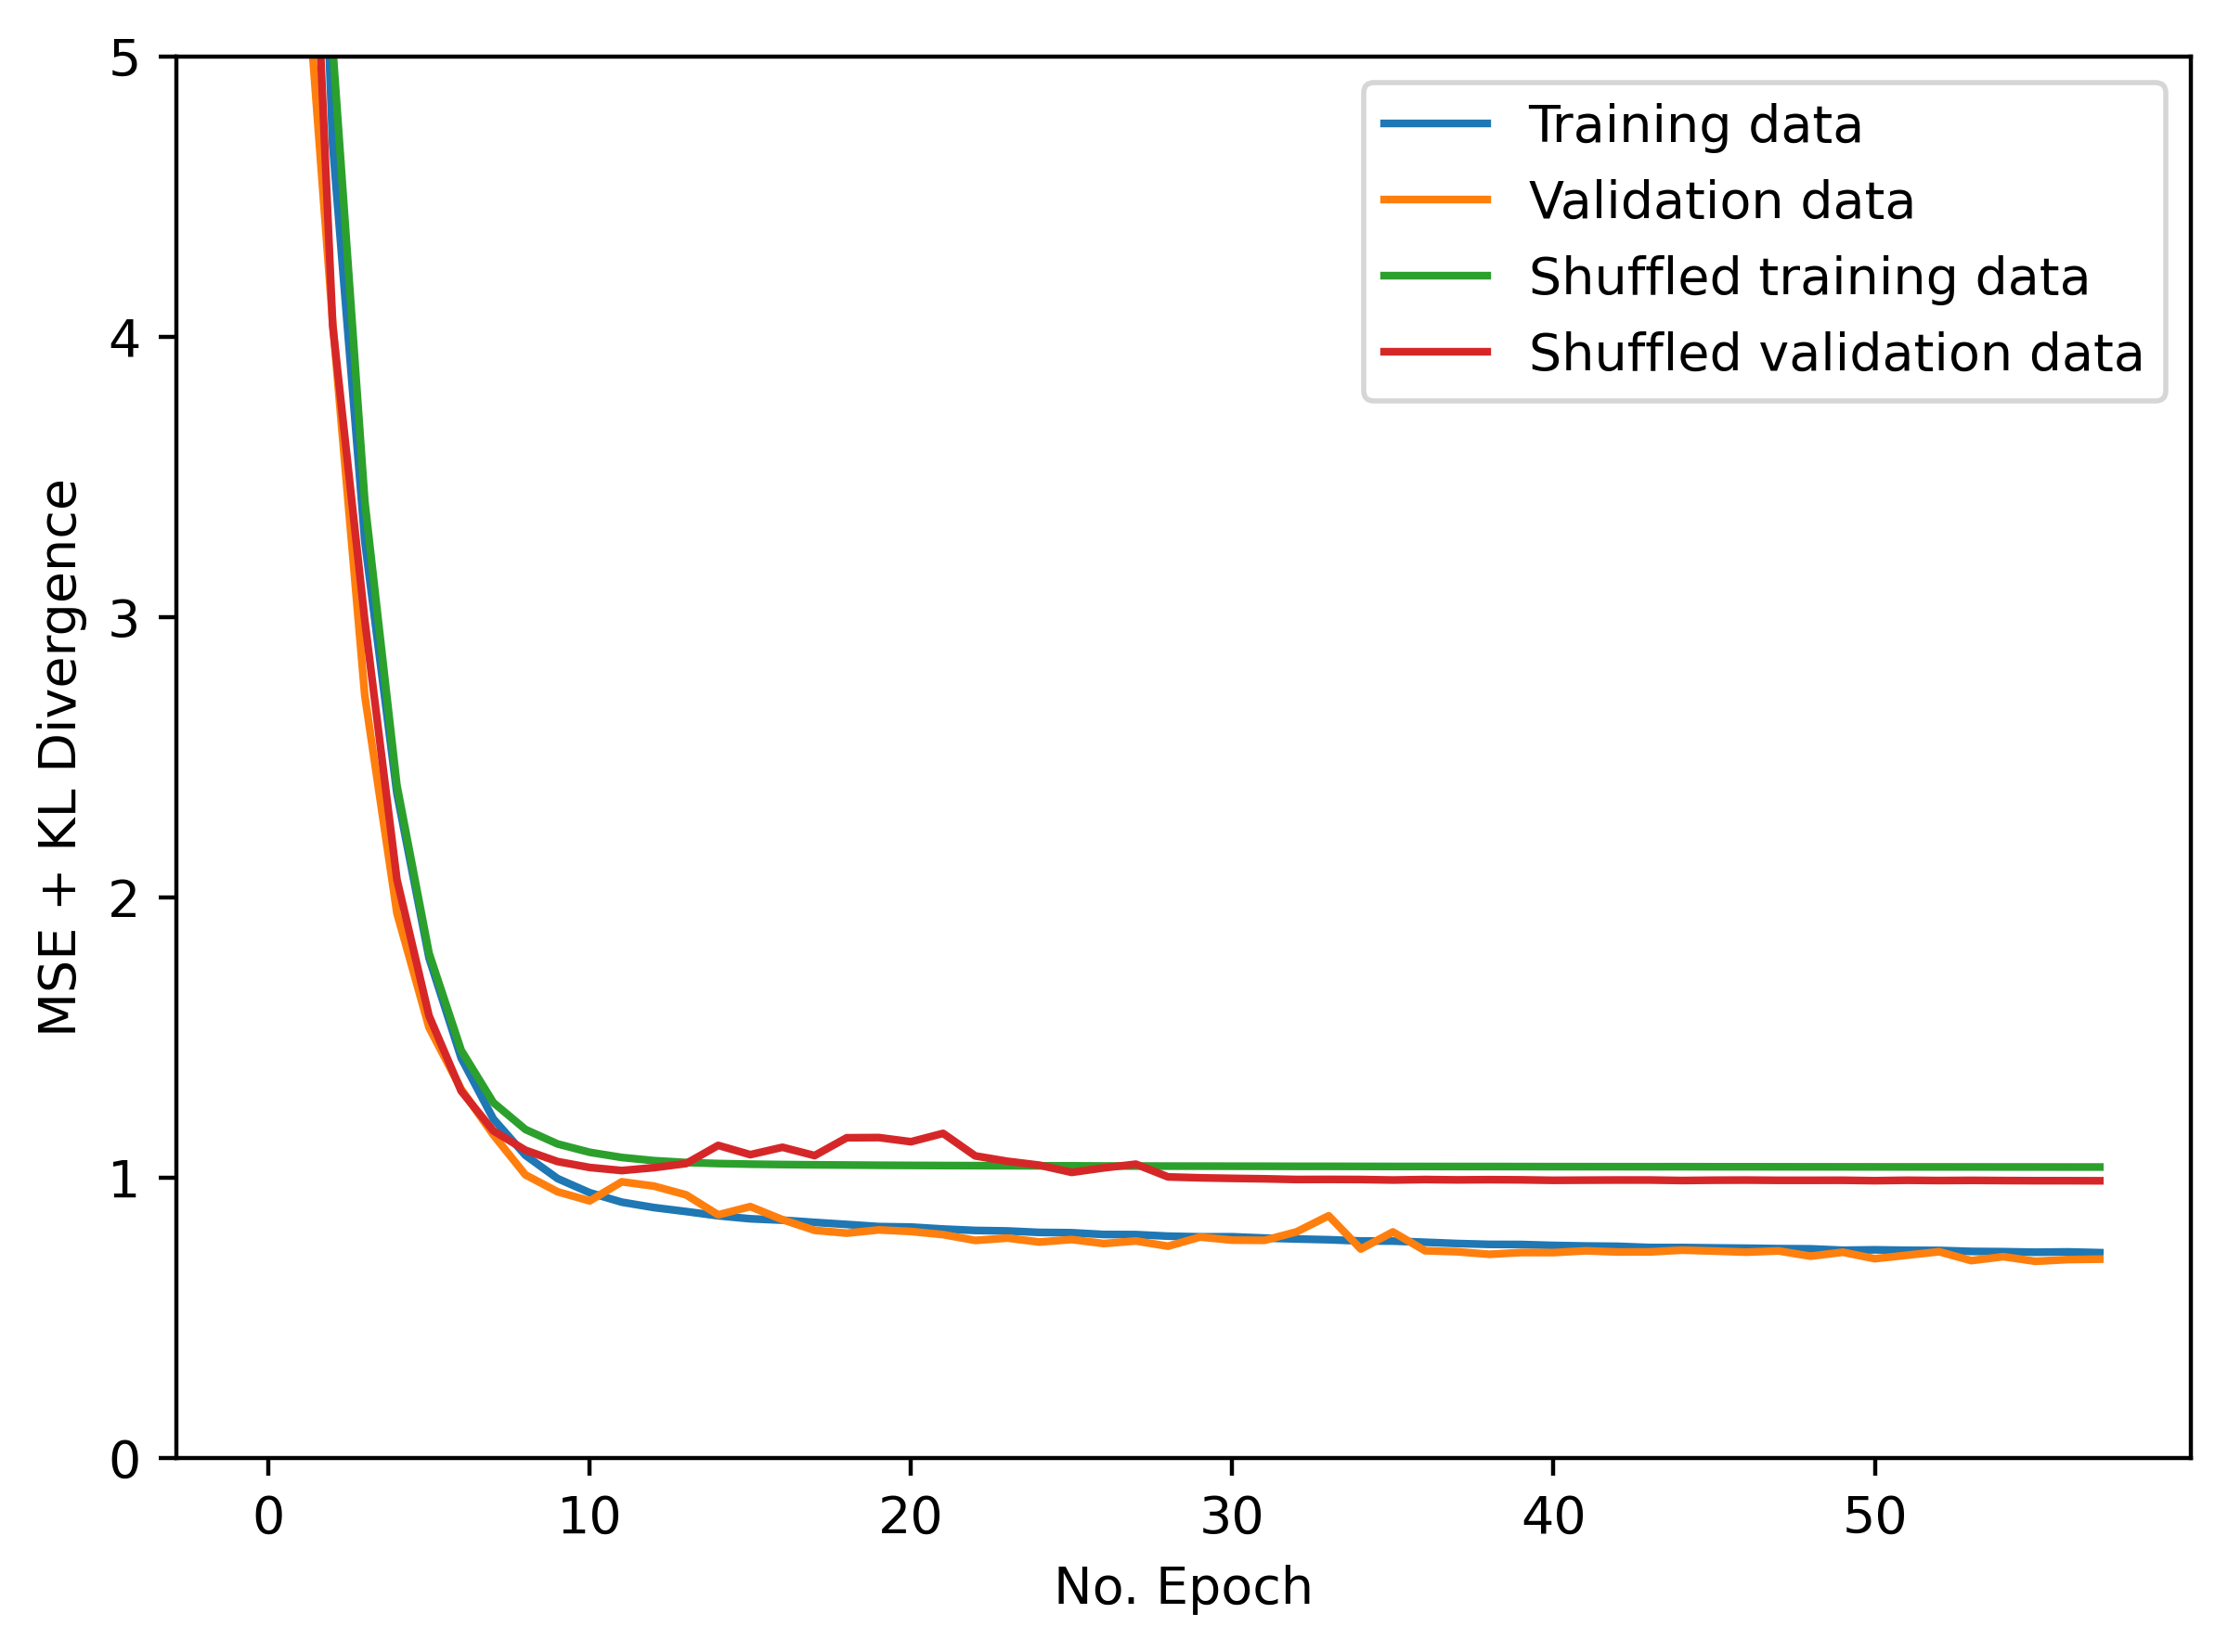

In [11]:
plt.figure(figsize=(7, 5), dpi = 400)
plt.plot(original_training_data["loss"], label="Training data")
plt.plot(original_training_data["val_loss"], label="Validation data")
plt.plot(history_df["loss"], label="Shuffled training data")
plt.plot(history_df["val_loss"], label="Shuffled validation data")
# plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.ylim(0,5)
plt.legend()
plt.show()

In [8]:
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=90,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=58,
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)
cp_vae.compile_vae()

In [9]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/58
1258/1258 [==============================] - 9s 5ms/step - loss: 135.8891 - recon: 53.0168 - kl: 17.8541 - mmd: 0.0000e+00 - val_loss: 24.9633 - val_recon: 10.6830 - val_kl: 14.2803 - val_mmd: 0.0000e+00
Epoch 2/58
1258/1258 [==============================] - 6s 5ms/step - loss: 16.3596 - recon: 6.6387 - kl: 6.2558 - mmd: 0.0000e+00 - val_loss: 8.9849 - val_recon: 4.8462 - val_kl: 4.1387 - val_mmd: 0.0000e+00
Epoch 3/58
1258/1258 [==============================] - 6s 5ms/step - loss: 6.2548 - recon: 3.8466 - kl: 1.4581 - mmd: 0.0000e+00 - val_loss: 4.2124 - val_recon: 3.1632 - val_kl: 1.0492 - val_mmd: 0.0000e+00
Epoch 4/58
1258/1258 [==============================] - 6s 5ms/step - loss: 3.4630 - recon: 2.6989 - kl: 0.4473 - mmd: 0.0000e+00 - val_loss: 2.9084 - val_recon: 2.3140 - val_kl: 0.5945 - val_mmd: 0.0000e+00
Epoch 5/58
1258/1258 [==============================] - 6s 5ms/step - loss: 2.4176 - recon: 2.0287 - kl: 0.2255 - mmd: 0.0000e+00 - val_loss: 1.9827 - val_recon

1258/1258 [==============================] - 6s 5ms/step - loss: 1.0379 - recon: 1.0401 - kl: 1.2510e-06 - mmd: 0.0000e+00 - val_loss: 0.9918 - val_recon: 0.9917 - val_kl: 6.9842e-05 - val_mmd: 0.0000e+00
Epoch 40/58
1258/1258 [==============================] - 6s 5ms/step - loss: 1.0397 - recon: 1.0402 - kl: 1.1323e-06 - mmd: 0.0000e+00 - val_loss: 0.9920 - val_recon: 0.9920 - val_kl: 5.3954e-05 - val_mmd: 0.0000e+00
Epoch 41/58
1258/1258 [==============================] - 6s 5ms/step - loss: 1.0405 - recon: 1.0400 - kl: 1.0679e-06 - mmd: 0.0000e+00 - val_loss: 0.9904 - val_recon: 0.9904 - val_kl: 3.4227e-05 - val_mmd: 0.0000e+00
Epoch 42/58
1258/1258 [==============================] - 6s 5ms/step - loss: 1.0396 - recon: 1.0398 - kl: 1.0270e-06 - mmd: 0.0000e+00 - val_loss: 0.9911 - val_recon: 0.9910 - val_kl: 3.5760e-05 - val_mmd: 0.0000e+00
Epoch 43/58
1258/1258 [==============================] - 6s 5ms/step - loss: 1.0389 - recon: 1.0397 - kl: 9.8763e-07 - mmd: 0.0000e+00 - val_los

In [10]:
cp_vae.vae

In [11]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,70.870865,53.016800,1.785412e+01,0.0,24.963261,10.682957,14.280306,0.0
1,12.894538,6.638731,6.255801e+00,0.0,8.984916,4.846186,4.138731,0.0
2,5.304684,3.846559,1.458132e+00,0.0,4.212414,3.163176,1.049239,0.0
3,3.146172,2.698914,4.472561e-01,0.0,2.908447,2.313952,0.594495,0.0
4,2.254292,2.028743,2.255487e-01,0.0,1.982696,1.750969,0.231726,0.0
5,1.753179,1.623325,1.298534e-01,0.0,1.714035,1.441589,0.272447,0.0
6,1.448938,1.380730,6.820745e-02,0.0,1.453047,1.257777,0.195269,0.0
7,1.267833,1.237739,3.009287e-02,0.0,2.457619,1.162226,1.295393,0.0
8,1.167626,1.157099,1.052865e-02,0.0,2.523368,1.092514,1.430855,0.0
9,1.110646,1.107494,3.152212e-03,0.0,2.346608,1.053555,1.293053,0.0


In [12]:
history_df.to_csv('level4_training_vanilla_random.csv')

In [12]:
# history_df = pd.read_csv('level4_training_vanilla_random.csv')

In [13]:
original_training_data  = pd.read_csv('level4_training_vanilla.csv')

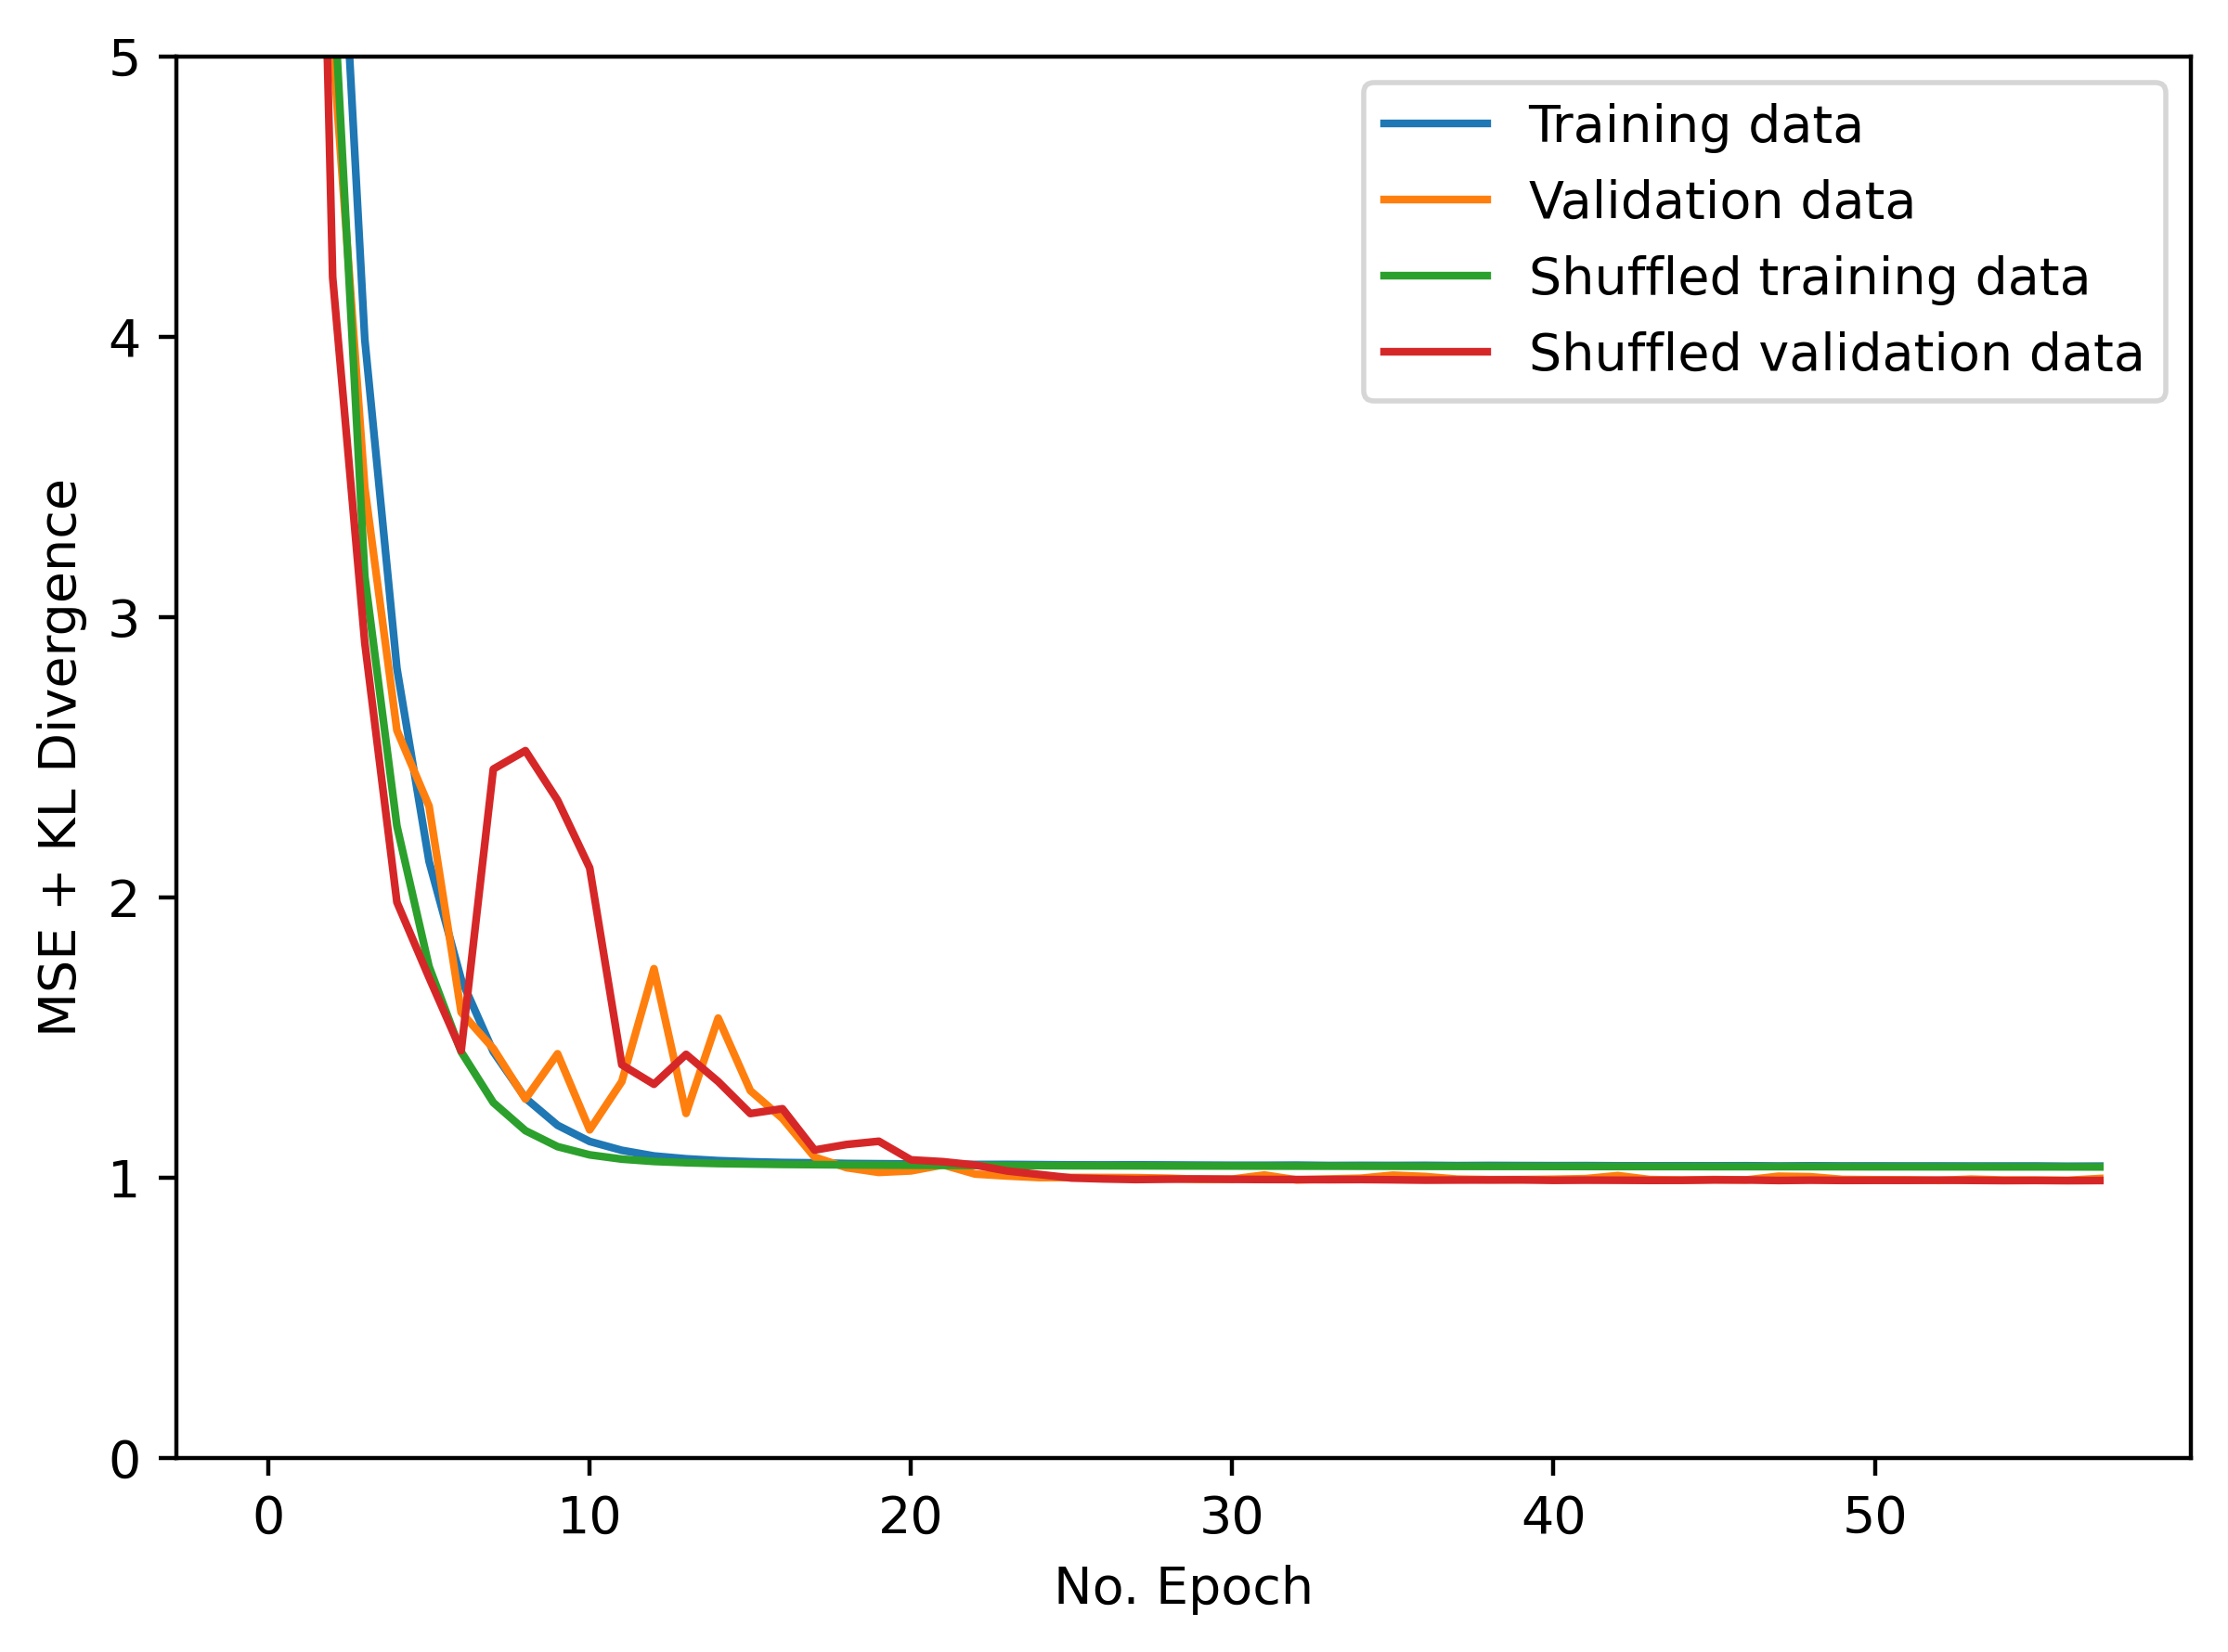

In [14]:
plt.figure(figsize=(7, 5), dpi = 400)
plt.plot(original_training_data["loss"], label="Training data")
plt.plot(original_training_data["val_loss"], label="Validation data")
plt.plot(history_df["loss"], label="Shuffled training data")
plt.plot(history_df["val_loss"], label="Shuffled validation data")
# plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.ylim(0,5)
plt.legend()
plt.show()

In [20]:
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=90,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=50,
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0,
    lam = 10000,
    verbose=True,
)
cp_vae.compile_vae()

In [21]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/50
1258/1258 [==============================] - 9s 6ms/step - loss: 139.6785 - recon: 53.3649 - kl: 0.0000e+00 - mmd: 22.5135 - val_loss: 35.1405 - val_recon: 10.7911 - val_kl: 0.0000e+00 - val_mmd: 25.0417
Epoch 2/50
1258/1258 [==============================] - 6s 5ms/step - loss: 26.3977 - recon: 7.0141 - kl: 0.0000e+00 - mmd: 17.3203 - val_loss: 23.8103 - val_recon: 5.1358 - val_kl: 0.0000e+00 - val_mmd: 18.5880
Epoch 3/50
1258/1258 [==============================] - 6s 5ms/step - loss: 19.9787 - recon: 4.1051 - kl: 0.0000e+00 - mmd: 15.1397 - val_loss: 21.9435 - val_recon: 3.3978 - val_kl: 0.0000e+00 - val_mmd: 18.2355
Epoch 4/50
1258/1258 [==============================] - 6s 5ms/step - loss: 17.4292 - recon: 2.7988 - kl: 0.0000e+00 - mmd: 14.1973 - val_loss: 18.1425 - val_recon: 2.3249 - val_kl: 0.0000e+00 - val_mmd: 16.1774
Epoch 5/50
1258/1258 [==============================] - 6s 5ms/step - loss: 15.9029 - recon: 2.0467 - kl: 0.0000e+00 - mmd: 13.6869 - val_loss: 17.44

In [22]:
cp_vae.vae

In [23]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,75.990425,53.364868,0.0,22.513519,35.140453,10.791061,0.0,25.041737
1,24.279604,7.014129,0.0,17.320341,23.810251,5.135759,0.0,18.587990
2,19.199734,4.105064,0.0,15.139734,21.943485,3.397774,0.0,18.235462
3,16.975109,2.798797,0.0,14.197268,18.142534,2.324863,0.0,16.177420
4,15.737158,2.046715,0.0,13.686887,17.444733,1.755896,0.0,16.194475
5,15.140857,1.613007,0.0,13.520715,17.441473,1.425231,0.0,15.966905
6,14.596785,1.364141,0.0,13.196935,16.813593,1.237390,0.0,15.740977
7,14.303734,1.223948,0.0,13.005540,16.251081,1.132922,0.0,15.581997
8,14.079176,1.143304,0.0,12.969540,16.124018,1.073999,0.0,15.338076
9,14.099072,1.098593,0.0,12.864768,15.654669,1.035008,0.0,14.881290


In [24]:
history_df.to_csv('level4_training_mmd_random.csv')

In [25]:
original_training_data  = pd.read_csv('level4_training_mmd.csv')

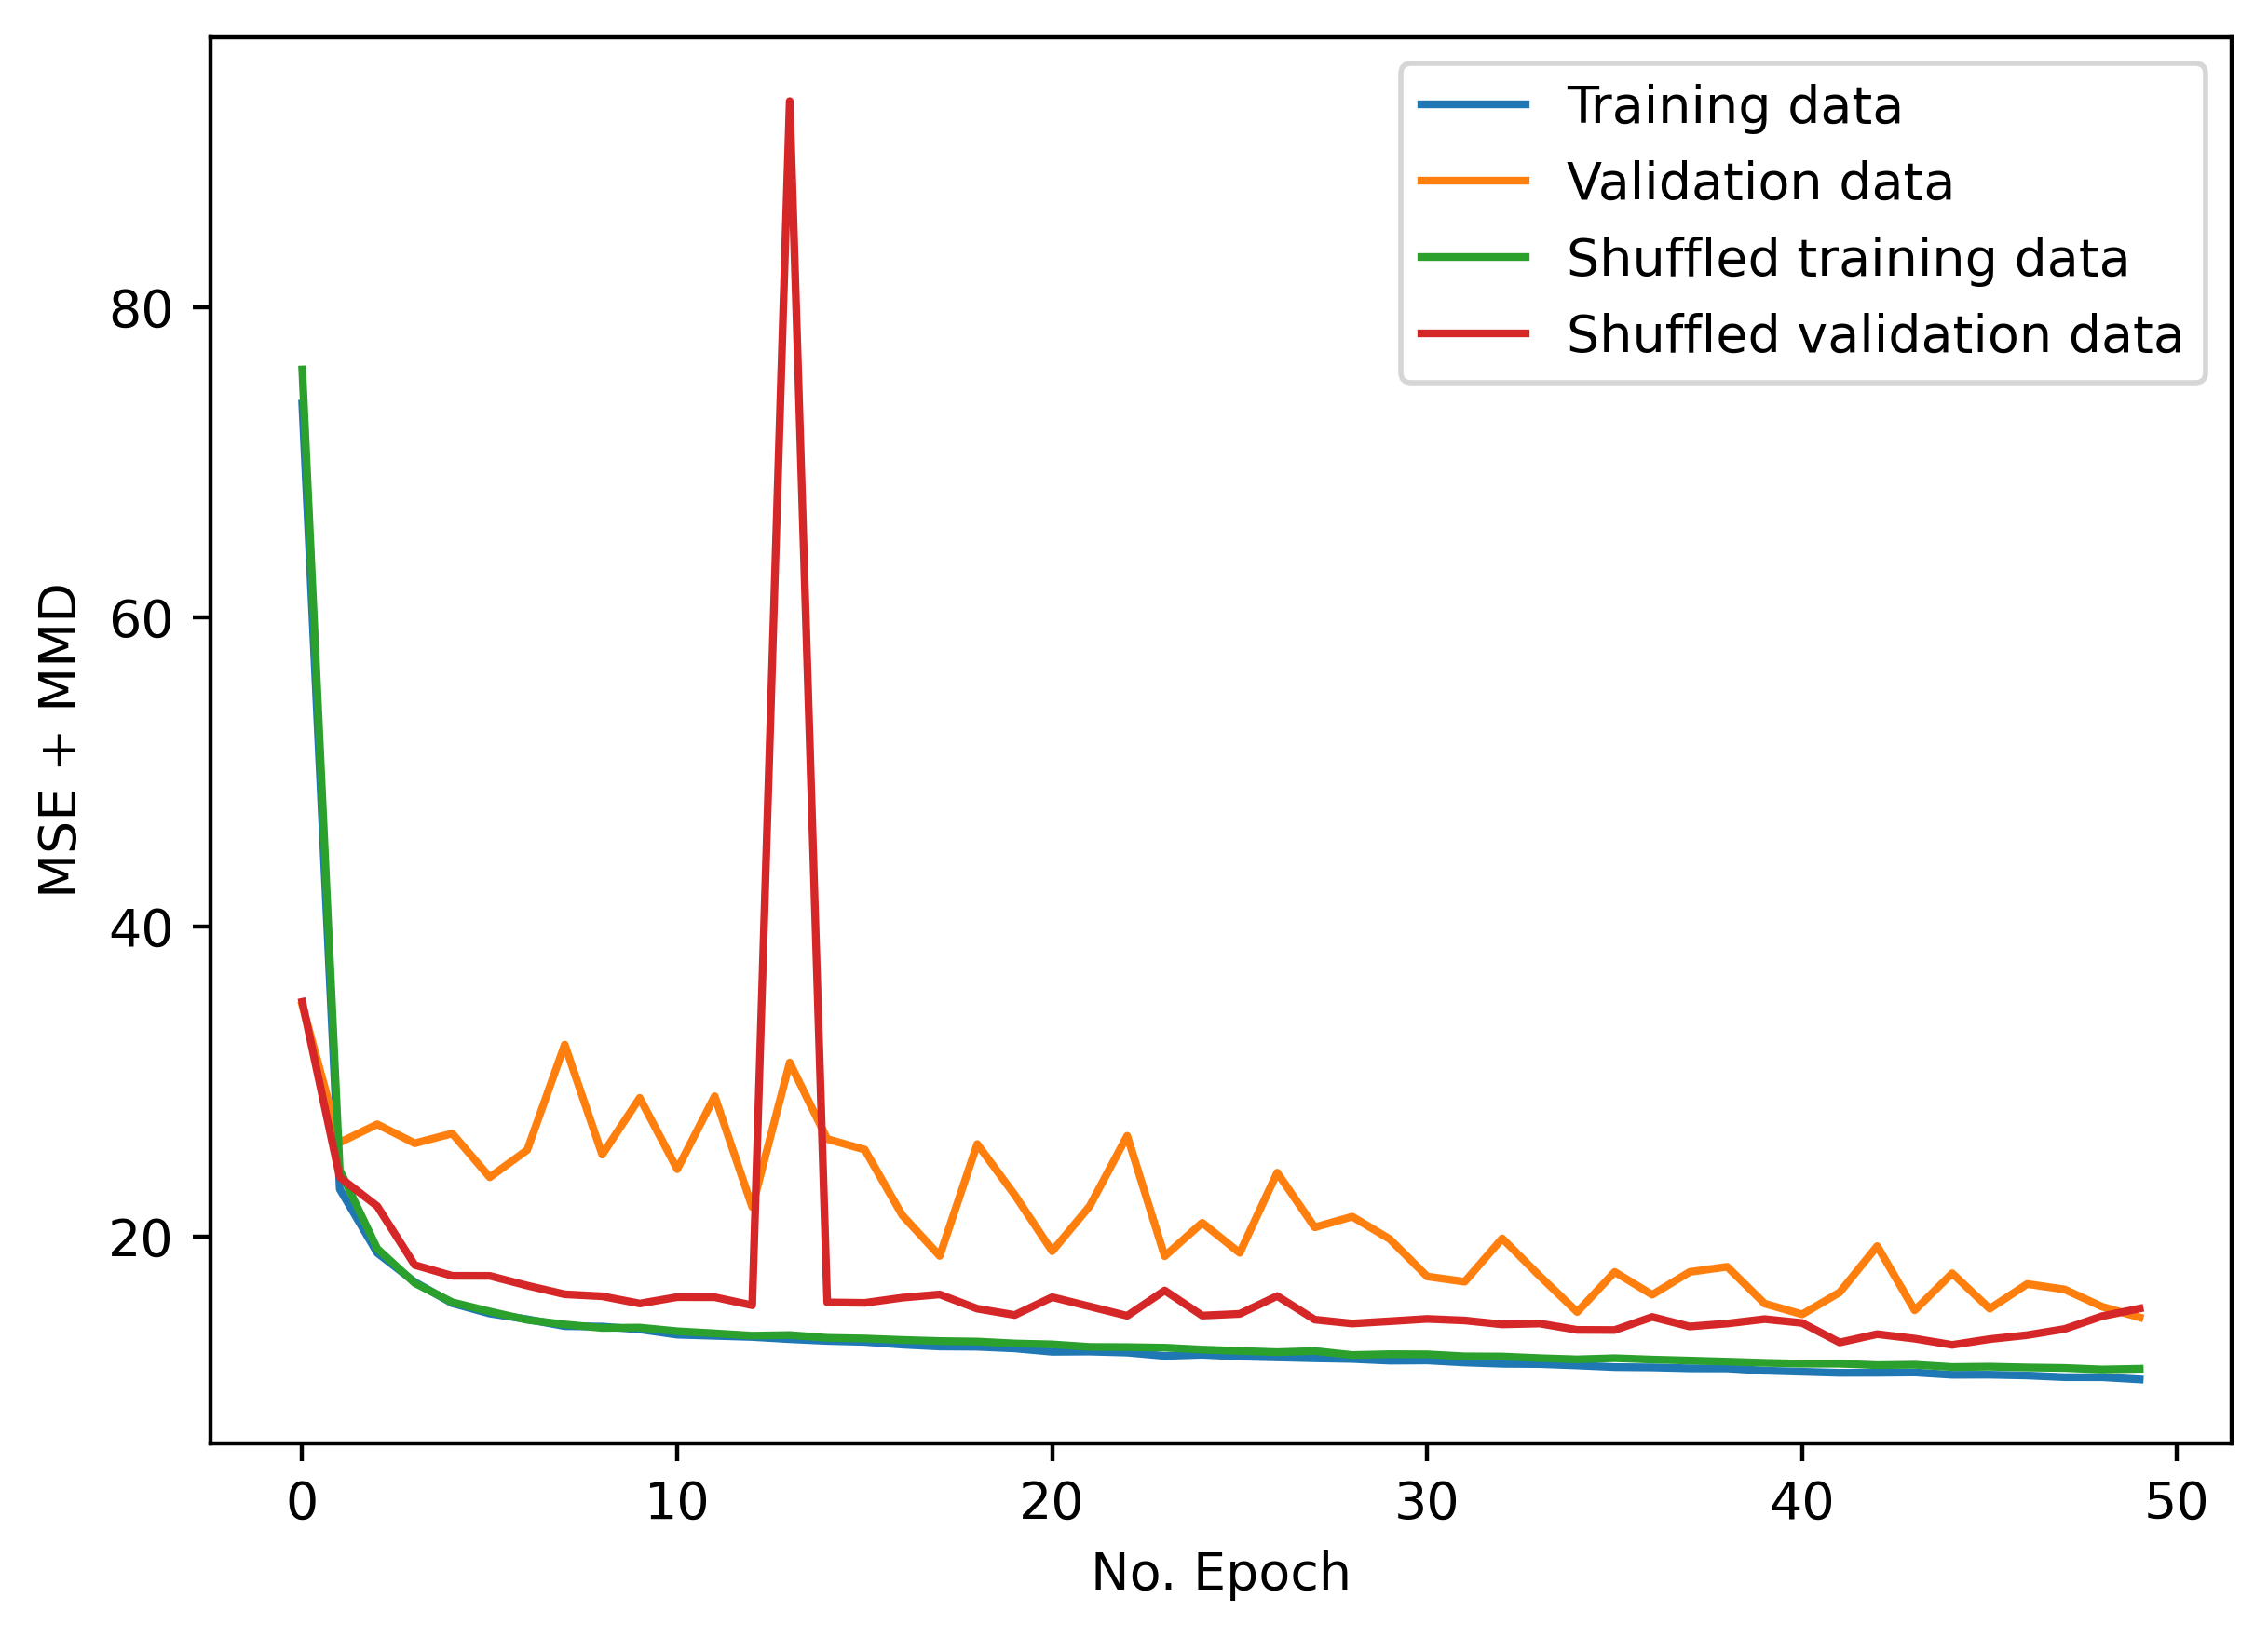

In [26]:
plt.figure(figsize=(7, 5), dpi = 400)
plt.plot(original_training_data["loss"], label="Training data")
plt.plot(original_training_data["val_loss"], label="Validation data")
plt.plot(history_df["loss"], label="Shuffled training data")
plt.plot(history_df["val_loss"], label="Shuffled validation data")
# plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + MMD")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()